         ┌───┐┌───┐ ░            ░      ┌───┐┌─┐         ░              
q1_0: |0>┤ Z ├┤ H ├─░────────────░───■──┤ H ├┤M├──────■──░──────────────
         └───┘└───┘ ░ ┌───┐      ░ ┌─┴─┐└┬─┬┘└╥┘      │  ░              
q1_1: |0>───────────░─┤ H ├──■───░─┤ X ├─┤M├──╫───■───┼──░──────────────
                    ░ └───┘┌─┴─┐ ░ └───┘ └╥┘  ║ ┌─┴─┐ │  ░ ┌───┐┌───┐┌─┐
q1_2: |0>───────────░──────┤ X ├─░────────╫───╫─┤ X ├─■──░─┤ H ├┤ Z ├┤M├
                    ░      └───┘ ░        ║   ║ └───┘    ░ └───┘└───┘└╥┘
 c1_0: 0 ═════════════════════════════════╬═══╩═══════════════════════╬═
                                          ║                           ║ 
 c1_1: 0 ═════════════════════════════════╩═══════════════════════════╬═
                                                                      ║ 
 c1_2: 0 ═════════════════════════════════════════════════════════════╩═
                                                                        
{'001': 257, '011': 247, '010': 264, '000': 256}


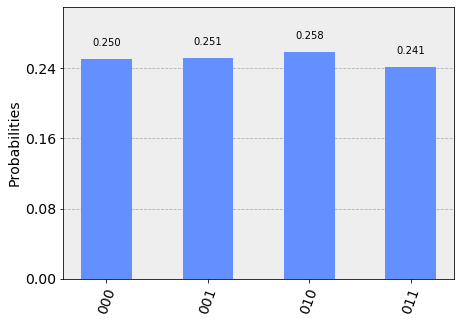

In [2]:
%matplotlib inline

# make the imports that are necessary for our work
import qiskit as qk

from qiskit import(
  ClassicalRegister,
  QuantumCircuit,
  QuantumRegister,  
  QuantumCircuit,
  execute,
  Aer)

#from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit
#from qiskit import execute, Aer
from qiskit import IBMQ
from qiskit.tools.visualization import plot_histogram

def apply_secret_unitary(secret_unitary, qubit, quantum_circuit, dagger):
    functionmap = {
                    'x':quantum_circuit.x,
                    'y':quantum_circuit.y,
                    'z':quantum_circuit.z,
                    'h':quantum_circuit.h,                    
                    't':quantum_circuit.t,                    
    }
    if dagger: functionmap['t'] = quantum_circuit.tdg
    
    if dagger:
        [functionmap[unitary](qubit) for unitary in secret_unitary]
    else:
        [functionmap[unitary](qubit) for unitary in secret_unitary[::-1]]
        
# Les porte appliquées au bit quantique secret à transmettre        
secret_unitary = 'hz'        
        
# Create the quantum circuit
q = QuantumRegister(3)
c = ClassicalRegister(3)
qc = QuantumCircuit(q, c)

# Apply the secret unitary that we are using to generate the state to teleport. You can change it to any unitary
apply_secret_unitary(secret_unitary, q[0], qc, dagger = 0)
qc.barrier()
# Next, generate the entangled pair between Alice and Bob (Remember: Hadamard followed by CX generates a Bell pair)
qc.h(q[1])
qc.cx(q[1], q[2])
qc.barrier()
# Next, apply the teleportation protocol. 
qc.cx(q[0], q[1])
qc.h(q[0])
qc.measure(q[0], c[0])
qc.measure(q[1], c[1])
qc.cx(q[1], q[2])
qc.cz(q[0], q[2])
qc.barrier()

'''
In principle, if the teleportation protocol worked, we have q[2] = secret_unitary|0>
As a result, we should be able to recover q[2] = |0> by applying the reverse of secret_unitary
since for a unitary u, u^dagger u = I.
'''
apply_secret_unitary(secret_unitary, q[2], qc, dagger=1)
qc.measure(q[2], c[2])        

# Draw the circuit
qc.draw()
print(qc)
qc.draw(output='mpl', filename='circuit.png')

backend = Aer.get_backend('qasm_simulator')
job_sim = execute(qc, backend, shots=1024)
sim_result = job_sim.result()

measurement_result = sim_result.get_counts(qc)
print(measurement_result)
plot_histogram(measurement_result)